# Kalman Filter
---

In [1]:
%matplotlib inline

In [2]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(style='white', context='talk')
from tqdm.notebook import tqdm

In [3]:
data = os.path.join('data', 'wall-following-robot', 'sensor_readings_2.data')

In [4]:
df_ = pd.read_csv(data, header=None, names=['x', 'y', 'action'])

In [5]:
df_.head()

,x,y,action
0,1.687,0.445,Slight-Right-Turn
1,1.687,0.449,Slight-Right-Turn
2,1.687,0.449,Slight-Right-Turn
3,1.687,0.449,Slight-Right-Turn
4,1.687,0.449,Slight-Right-Turn


In [6]:
k = 20
n = 100

In [7]:
tscv = TimeSeriesSplit(n_splits=k, max_train_size=n)

In [8]:
idx = np.random.randint(k)

In [9]:
df = df_.loc[list(tscv.split(df_))[idx][0]].copy()

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
def predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    
    return X, P 

In [12]:
def update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y - IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    
    LH = gauss_pdf(Y, IM, IS)
        
    return X, P, K, IM, IS, LH

In [13]:
def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - np.tile(M, X.shape[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = np.tile(X, M.shape[1]) - M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X - M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)

    return P[0], E[0]

### Example

Set time step.

In [14]:
dt = .1

Initialize state matrices.

In [15]:
X = np.array([[0.0], [0.0], [dt], [dt]])
P = np.diag((dt, dt, dt, dt))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0], 1)) 

Initialize measurement matrices.

In [16]:
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(2) 

Applying the Kalman Filter to data.

In [17]:
obs = pd.DataFrame(columns=['x', 'y'])
pred = pd.DataFrame(columns=['x', 'y'])

pbar = tqdm(df.iterrows(), total=df.shape[0])
mse = 0
for i, row in pbar:
    if i == 0:
        X = np.array([[row['x']], [row['y']], [dt], [dt]])
        
    X, P = predict(X, P, A, Q, B, U)
    Y = np.array([row['x'], row['y']]).reshape(2, 1)  # observation

    X, P, K, IM, IS, LH = update(X, P, Y, H, R)
    
    obs = obs.append({'x': Y[0, 0], 'y': Y[1, 0]}, ignore_index=True)
    pred = pred.append({'x': IM[0, 0], 'y': IM[1, 0]}, ignore_index=True)
    
    dY = Y - IM
    mse += np.sum(np.power(Y - IM, 2)) / np.size(Y)
    
    pbar.desc = f"MSE = {mse:.2f}"

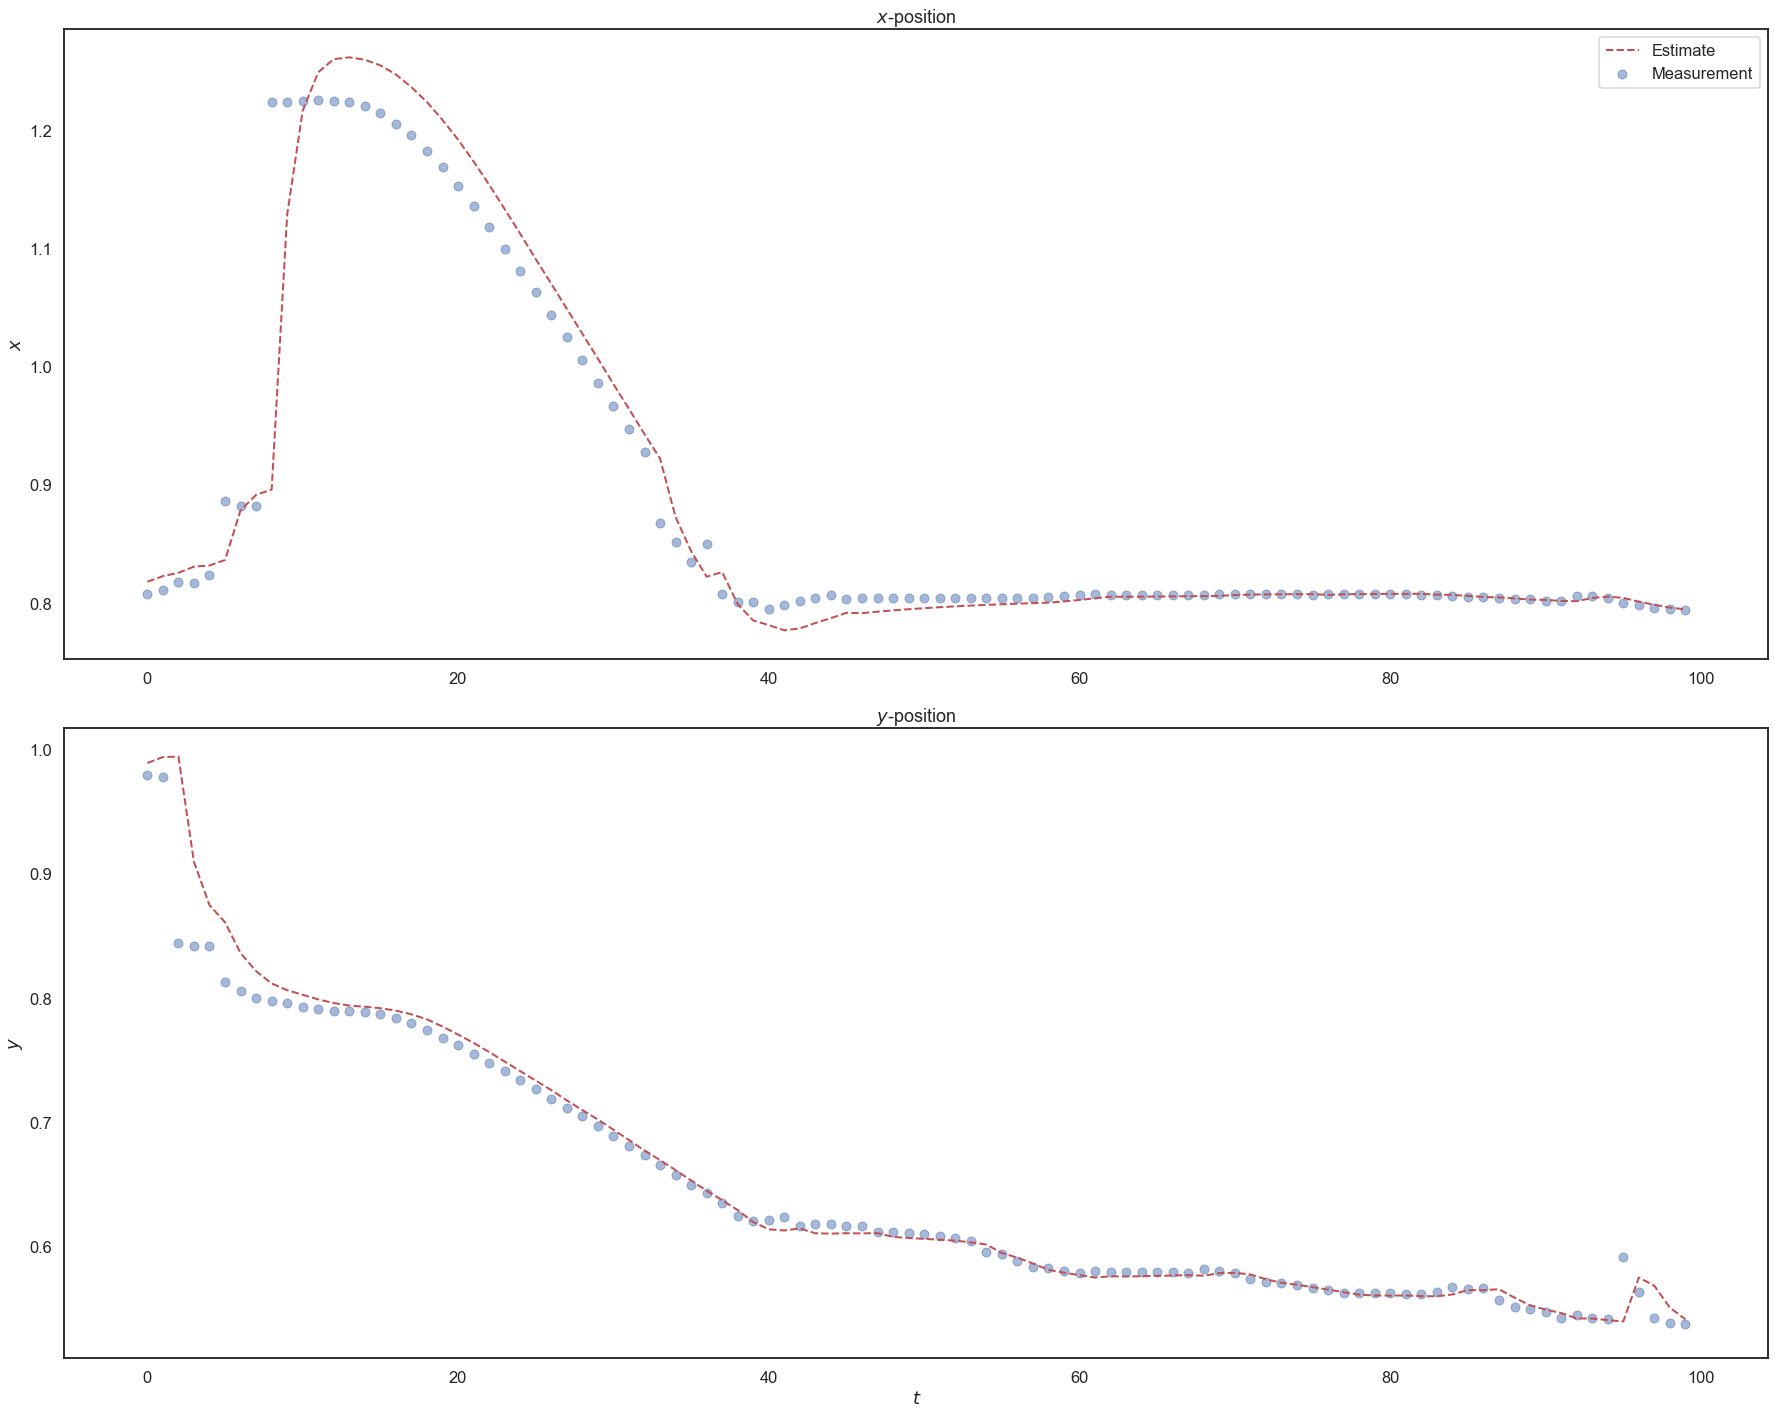

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20))

ax1.plot(pred.index, pred['x'], label="Estimate", linestyle='--', color='r', lw=2)
ax1.scatter(obs.index, obs['x'], label="Measurement", marker='o', lw=1, alpha=.5)

ax1.set(
    title="$x$-position",
    ylabel="$x$",
)
ax1.legend()

ax2.plot(pred.index, pred['y'], label="Estimate", linestyle='--', color='r', lw=2)
ax2.scatter(obs.index, obs['y'], label="Measurement", marker='o', lw=1, alpha=.5)

ax2.set(
    title="$y$-position",
    xlabel="$t$",
    ylabel="$y$",
)

# ax2.legend()
plt.tight_layout();

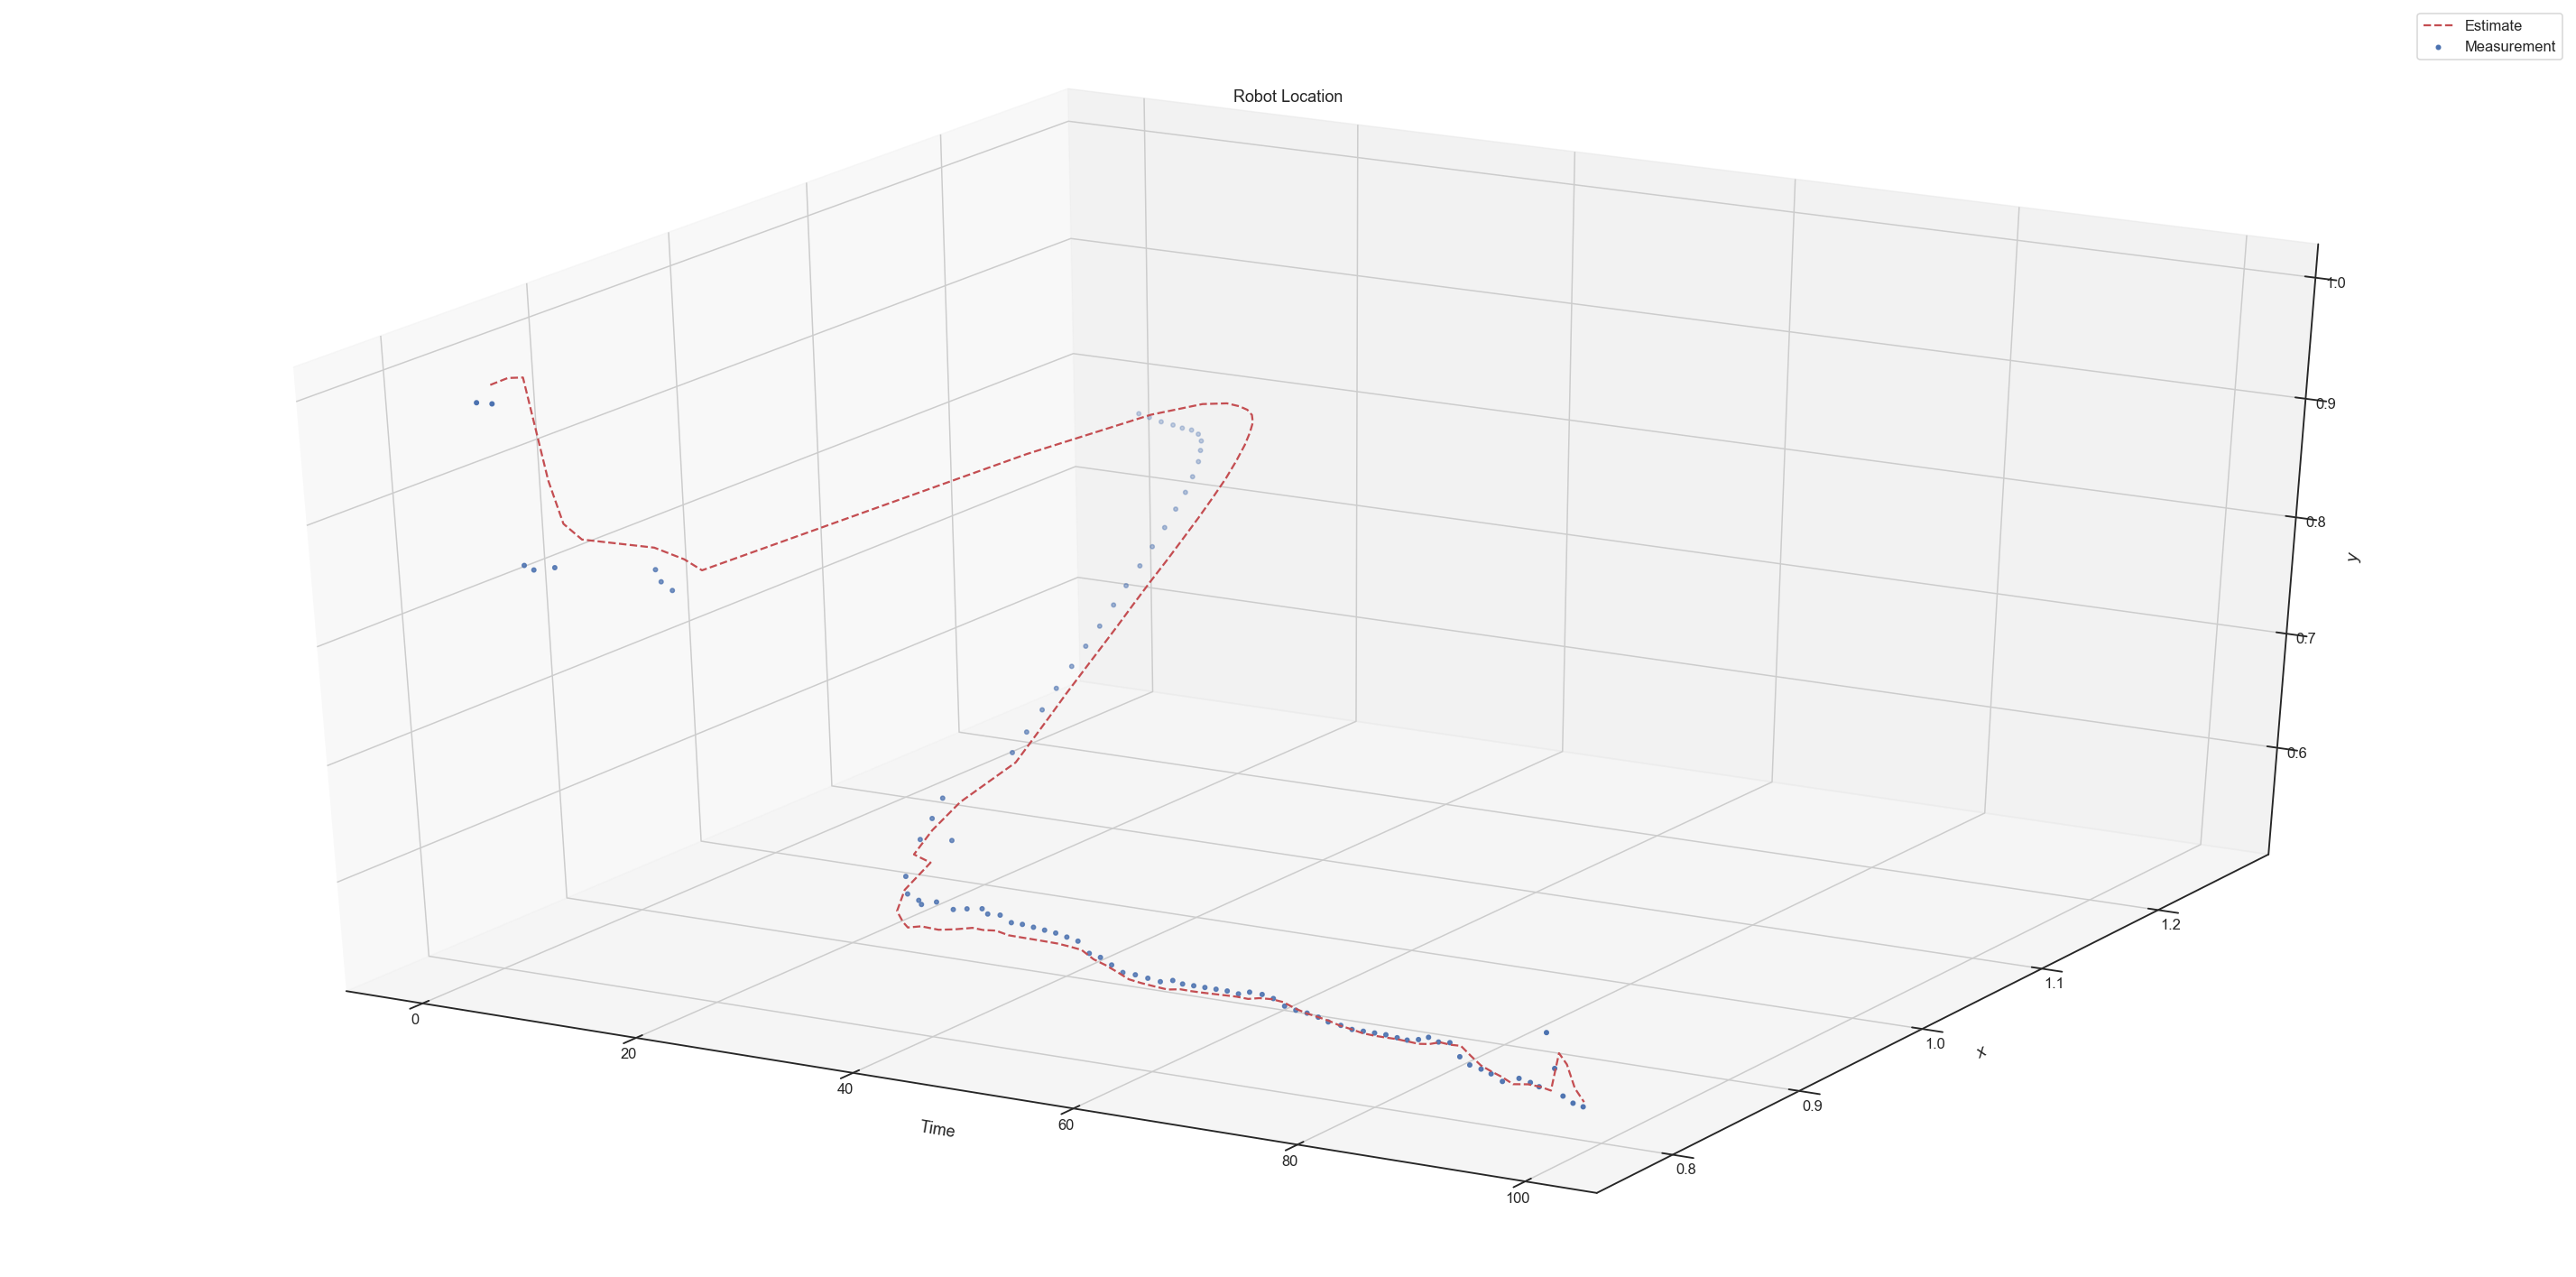

In [19]:
fig = plt.figure(figsize=(40, 20))
ax = fig.gca(projection='3d')

ax.scatter(obs.index, obs['x'], obs['y'], label="Measurement", marker='o')
ax.plot(pred.index, pred['x'], pred['y'], label="Estimate", linestyle='--', color='r')

ax.set(
    title='Robot Location',
    xlabel='\n\nTime',
    ylabel='\n\n$x$',
    zlabel='\n\n$y$',
)

plt.legend()
plt.tight_layout();